## Introduction

First we load the necessary packages. Additionally, the data is imported. 

In [215]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy import stats
from sklearn.tree import plot_tree
import pandas as pd
import arff
data_freq = arff.load('D:/DS/Challenges/HUK/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower","VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('D:/DS/Challenges/HUK/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

The data frame "df_freq" contains the features of policyholders plus the amount of exposure. The data frame "df_sev" contains the "ClaimAmount" for some of these policyholders. The tables can be merged using "IDpol" column. This results in a new data frame containing all the policyholders who recieved an amount upon making claims. Note that, we only consider entries for which the ClaimAmount exist. The entries which do not have a corresponding ClaimAmount are considered as unsetelled claims. Additionally, entries for which an amount is claimed but the features do not exist are considered as missing. These entries are omitted. 

We notice that, there are policyholders with more than one claim. For these policyholders, we will sum up the amount of their claims. In this way, multiple entries corresponding to these policyholders will be replaced with one entry. 

In [216]:
# Merging 2 datasets
df = pd.merge(df_freq, df_sev, how = 'inner', on = 'IDpol')
# Grouping by claim numbers and summing up the amount of claims per policyholder
df = df.groupby(by = list(df.columns[0:-1]), as_index = False).sum()
# moving the Exposure column to the end of dataframe
ex = df.pop('Exposure')
df.insert(11, ex.name, ex)

df

,IDpol,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimAmount
0,139.0,1.0,'F',7.0,1.0,61.0,50.0,'B12',Regular,27000.0,'R11',0.75,303.00
1,190.0,1.0,'B',12.0,5.0,50.0,60.0,'B12',Diesel,56.0,'R25',0.14,1981.84
2,414.0,1.0,'E',4.0,0.0,36.0,85.0,'B12',Regular,4792.0,'R11',0.14,1456.55
3,424.0,2.0,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',0.62,10834.00
4,463.0,1.0,'A',5.0,0.0,45.0,50.0,'B12',Regular,12.0,'R73',0.31,3986.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24939,6113521.0,1.0,'C',4.0,1.0,26.0,60.0,'B12',Diesel,311.0,'R82',0.18,1324.40
24940,6113793.0,1.0,'C',7.0,2.0,51.0,50.0,'B12',Diesel,178.0,'R72',0.14,1769.88
24941,6113817.0,1.0,'D',4.0,0.0,35.0,51.0,'B12',Regular,1719.0,'R82',0.17,1288.28
24942,6113834.0,2.0,'C',15.0,3.0,36.0,50.0,'B12',Regular,181.0,'R54',0.17,12230.40


We drop the IDpol column as it is not needed anymore. Additionally, the claim number is determined only after making claims and can not be considered a predictive feature. Hence we drop it! Of note, the aggregated data contains no missing values.

In [217]:
# Drop IDpol: The IDpol is not needed anymore
df = df.drop(columns = ['IDpol', 'ClaimNb'])
df.isna().sum()

Area           0
VehPower       0
VehAge         0
DrivAge        0
BonusMalus     0
VehBrand       0
VehGas         0
Density        0
Region         0
Exposure       0
ClaimAmount    0
dtype: int64

## Exploratory Data Analysis

We start by producing the fundamental descriptive statistcs of the data.

In [218]:
df.describe()

,VehPower,VehAge,DrivAge,BonusMalus,Density,Exposure,ClaimAmount
count,24944.000000,24944.000000,24944.000000,24944.000000,24944.000000,24944.000000,2.494400e+04
mean,6.468970,7.386225,45.139793,64.930164,1984.306166,0.692669,2.401749e+03
std,2.012848,5.173621,14.658487,19.864719,4119.719566,0.313969,3.026475e+04
min,4.000000,0.000000,18.000000,50.000000,2.000000,0.002740,1.000000e+00
25%,5.000000,3.000000,34.000000,50.000000,111.000000,0.450000,7.497875e+02
50%,6.000000,7.000000,45.000000,55.000000,495.000000,0.760000,1.172000e+03
75%,7.000000,11.000000,54.000000,76.000000,2120.000000,1.000000,1.346400e+03
max,15.000000,99.000000,99.000000,228.000000,27000.000000,2.000000,4.075401e+06


The claim amount variable has a price unit and it is disproportionally (75% of data points are less than 2000 and max value is in millions). In order to be able to explore the data properly, the log transform of this variable will be considered. In this way, not only the variable is scaled closer to the other continuous variables, but also the normality of the variable can be checked. 

In [219]:
df_explore = df.copy(deep = True)
df_explore['ClaimAmount'] = np.log10(df_explore['ClaimAmount'])

Next we plot the histogram of ClaimAmount. To check the normality further, we also produce the Q-Q plots against the standard normal distribution. Furthermore, the Pearson (linear) correlation between continuous variabes are derived. 

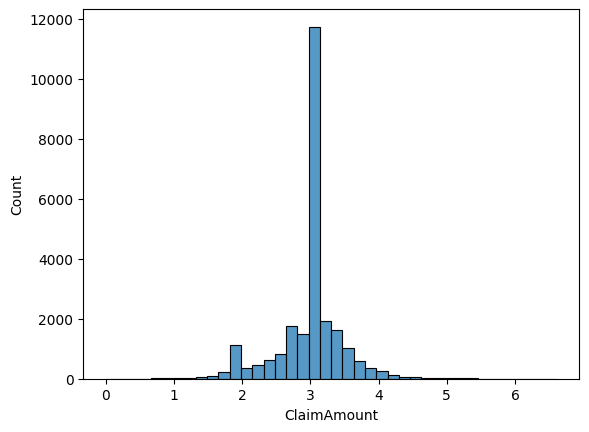

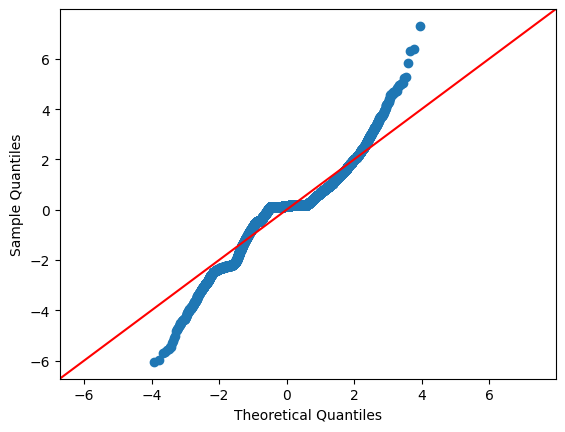

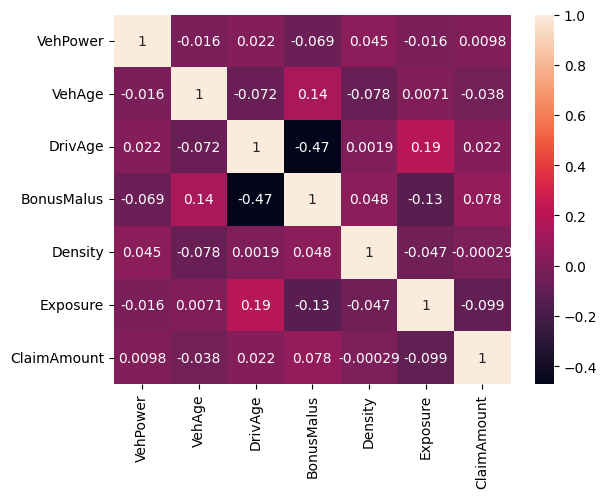

In [220]:
# Correlation between variables
sns.histplot(x = 'ClaimAmount', data = df_explore, bins = 40)
ca = df_explore['ClaimAmount']
ca = (ca - ca.mean())/(ca.std())
sm.qqplot(data = ca, line = '45')
plt.subplots()
sns.heatmap(df_explore.select_dtypes(include = 'float').corr(), annot = True)
plt.show()

The ClaimAmount looks non-normal. The distribution is not completely symmetric Around than 50% of values are also concentrated in a small range (i.e., extereme kurtosis). The Q-Q plots actually show the discrepency to the standard normal distribution much better. The tails of the ClaimAmount distribution departure from those of the normal distribution.  

Furthermore, the correlation coefficients between features and response are small. The highest linear coefficient is found between Exposure and DrivAge (0.19). This at least disproves the linear relation between the continuous features and the responses. 

In the following we apply further EDA:

Area: Clearly, Exposure has high dependency with the "Area". The information contained in "Density" is contained also in "Area". The 3rd plot shows that number of claims in higher denisty area 'F' is less than the rest of the areas. 

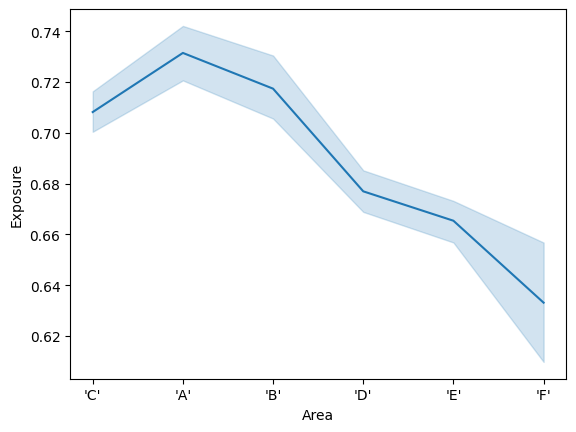

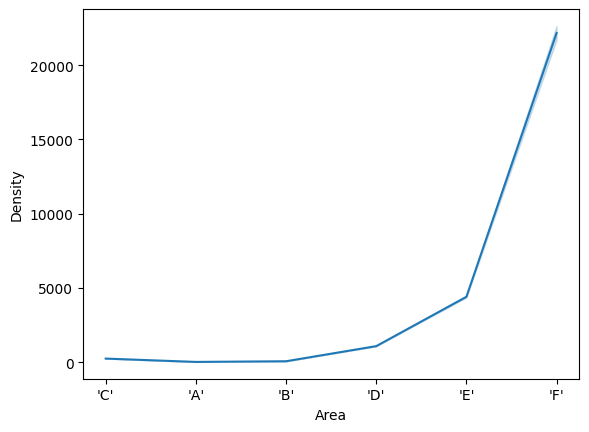

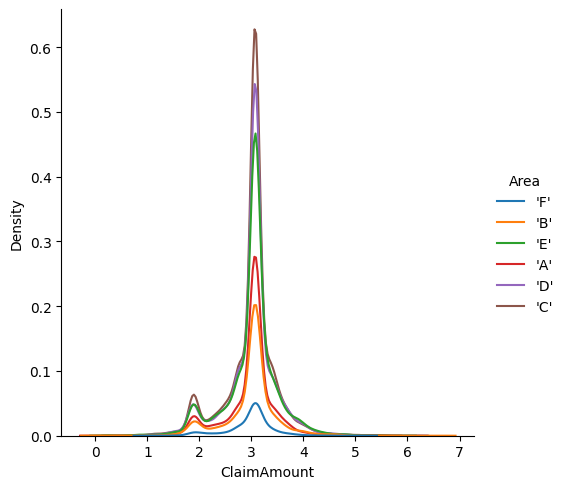

In [221]:
sns.lineplot(x = 'Area', y = 'Exposure', data = df_explore.sort_values(by="Exposure"))
plt.subplots()
sns.lineplot(x = 'Area', y = 'Density', data = df_explore.sort_values(by="Exposure"))
sns.displot(x = 'ClaimAmount', hue = 'Area', data = df_explore, kind = 'kde')
plt.show()

Region: It seems that Region is not a good indicator for Claim Amount or Exposure, hence we can omit it from the features.

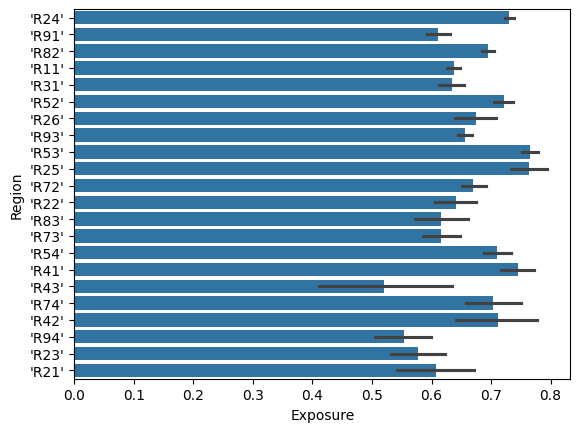

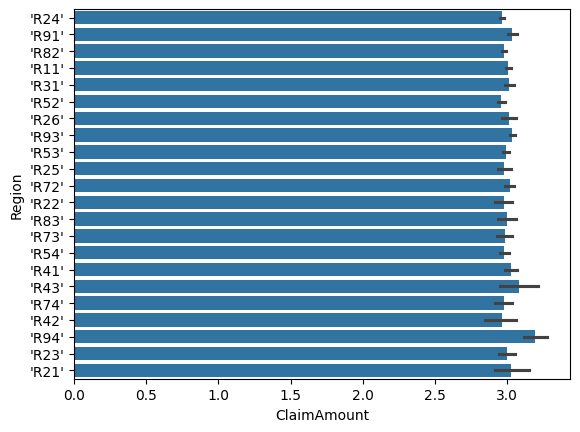

In [222]:
sns.barplot(y = 'Region', x = 'Exposure', data = df_explore.sort_values(by="Exposure"))
plt.subplots()
sns.barplot(y = 'Region', x = 'ClaimAmount', data = df_explore.sort_values(by="Exposure"))
plt.show()

DrivAge: There is a apparent correlation between driving age and the exposure. Additionally, the bonus-malus decreases with the driving age. This correlation almost occurs linearly (with coefficient -0.47 as can be seen in the table of correlation coefficients)

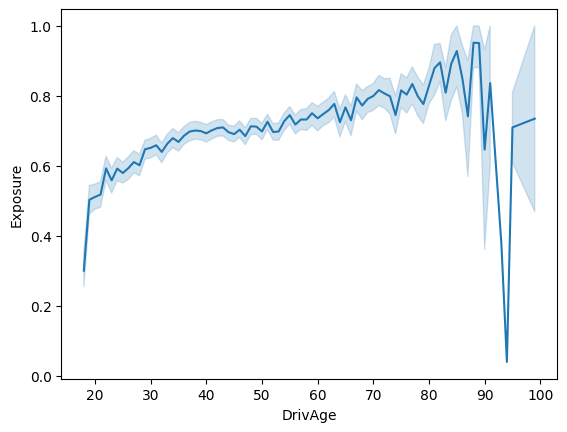

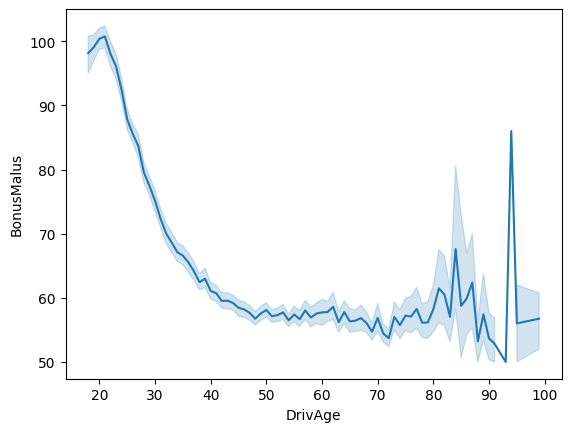

In [223]:
sns.lineplot(x = 'DrivAge', y = 'Exposure', data = df_explore)
plt.subplots()
sns.lineplot(x = 'DrivAge', y = 'BonusMalus', data = df_explore)
plt.show()

VehBrand: Some brands which have mostly low vehicle power submitted more claims.  

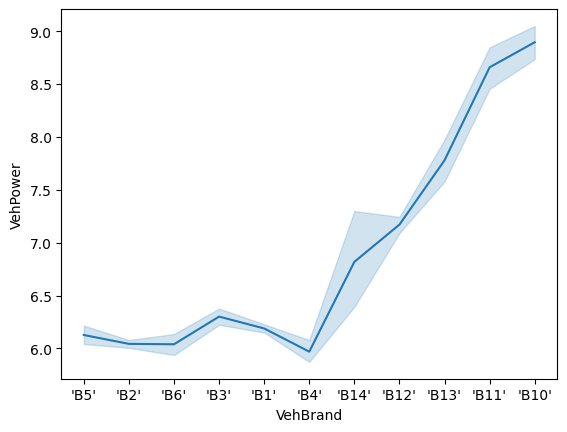

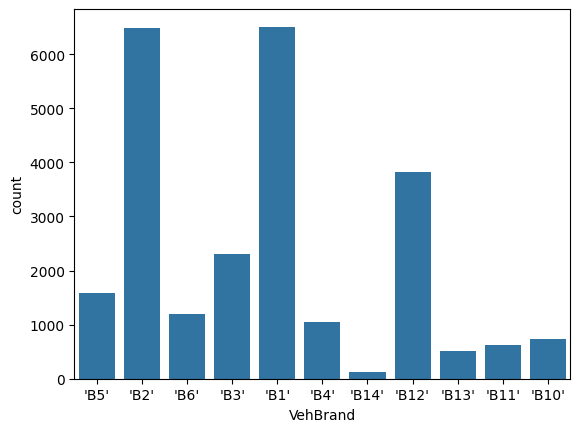

In [224]:
sns.lineplot(x = 'VehBrand', y = 'VehPower', data = df_explore.sort_values(by = 'VehPower'))
plt.subplots()
sns.countplot(x = 'VehBrand', data = df_explore.sort_values(by = 'VehPower'))
plt.show()

VehAge: The plots show that although old vehicles submit significantly fewer claims, but higher claim amounts. This is probably because most old cars are vintage cars. It is apparent these cases are outliers. 

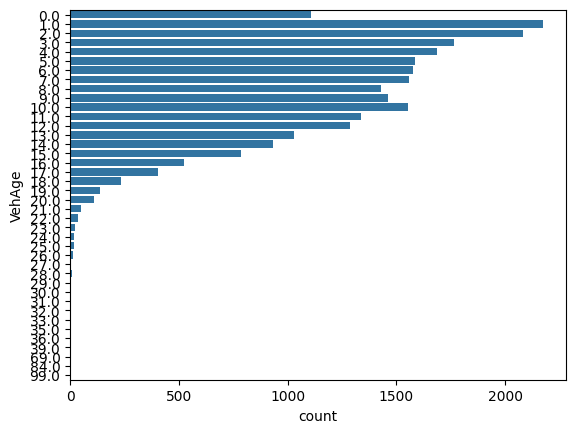

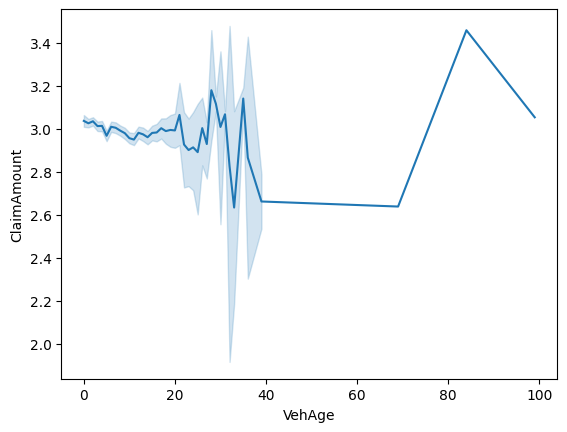

In [225]:
sns.countplot(y = 'VehAge', data = df_explore)
plt.subplots()
sns.lineplot(x = 'VehAge', y = 'ClaimAmount', data = df_explore)
plt.show()

## Results

As we have seen, the ClaimAmount do not follow a normal distribution even after log transformation. Additionally, there is no clear indication of linear dependence between features and responses. Therefore, we decide to proceed with decision trees. Additionally, we invetigate the more suitable ensemble methods for our learning process: random forrests and stochastic gradient descents. It is needless to say that we are dealing with numerical responses and hence our problem is of type regression. 

To address the model performance we choose the root-mean-squared error (RMSE).

### Feature Engineering
Decision trees make inform decisions on stratifying the data based on the information gain by different features. Hence, we will limit the process of feature selection and leave it to the model for optimization. Additionally, we refrain from transforming the claim amounts. This will allow the model to consider the effect of outliers. 

We consider the following feature engineering steps:
1. Dropping Density and Region (the claim amount is evenly distributed between regions and the information contained in density is most probably contained in the area variable)
2. Aggregate brands into 2 categories of high claim numbers and low claim numbers  
3. Converting the categorical features to numeric.


In [226]:
# droping density and region
dfx = df.drop(columns = ['Density', 'Region'])

# brand mapping
dfx["VehBrand"] = dfx["VehBrand"].str.replace("'","")
brand_mapping = {'B1':'high', 'B2':'high', 'B3':'few', 'B4':'few', 'B5':'few', 'B6':'few', 'B12':'few' , 'B10':'few', 'B11':'few', 'B13':'few', 'B14':'few'}
brands = dfx.VehBrand.map(brand_mapping)
dfx['Brands'] = brands
dfx.drop(columns = 'VehBrand')

# categories to numbers
col = dfx.select_dtypes(include='object').columns
dfx[col] = dfx.select_dtypes(include='object').astype('category')

for c in col:
    dfx[c] = dfx[c].cat.codes

dfx

,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Exposure,ClaimAmount,Brands
0,5,7.0,1.0,61.0,50.0,3,1,0.75,303.00,0
1,1,12.0,5.0,50.0,60.0,3,0,0.14,1981.84,0
2,4,4.0,0.0,36.0,85.0,3,1,0.14,1456.55,0
3,5,10.0,0.0,51.0,100.0,3,1,0.62,10834.00,0
4,0,5.0,0.0,45.0,50.0,3,1,0.31,3986.67,0
...,...,...,...,...,...,...,...,...,...,...
24939,2,4.0,1.0,26.0,60.0,3,0,0.18,1324.40,0
24940,2,7.0,2.0,51.0,50.0,3,0,0.14,1769.88,0
24941,3,4.0,0.0,35.0,51.0,3,1,0.17,1288.28,0
24942,2,15.0,3.0,36.0,50.0,3,1,0.17,12230.40,0


### Model

Before we proceed with modeling, we will create a few functions and variables to fecelitate the process. 

In [227]:
# setting up hyper-parameters
seed = 123
min_leaves = 0.2
min_split = 0.2
depth = 5
estimators_num = 500
responses = ['ClaimAmount', 'Exposure']

In [228]:
# splitting data to train and test datasets
X = dfx.drop(responses, axis = 1)
def data_prep (data, response):
    y = data[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)
    return X_train, X_test, y_train, y_test

In [229]:
# Plots
def plots(features, model, claim_pred, claim_test, exp_pred, exp_test):
    # feature importance
    important_features = pd.Series(model.feature_importances_, index = features).sort_values()
    important_features.plot(kind = 'barh')
    '''plt.subplots()
    res1 = claim_test - claim_pred
    res1 = (res1 - res1.mean())/res1.std()
    print(res1.max())
    plt.scatter(x = claim_pred, y = claim_test, s = 4) 
    plt.subplots()
    res2 = exp_test - exp_pred
    res2 = (res2 - res2.mean())/res2.std()
    plt.scatter(x = exp_pred, y = res2, s = 4)'''
    plt.show()
    

In [233]:
## RMSE
def model_performance(X_train, X_test, y_train, y_test, model):
    train_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, train_pred, multioutput = 'raw_values')**(1/2)
    print('Training RMSE: ' + str(rmse_train))
    y_pred = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred, multioutput = 'raw_values')**(1/2)
    print('Test RMSE: ' + str(rmse_test))
    if len(y_train) == 2:
        plots(X.columns, model, y_pred[:,0], y_test['ClaimAmount'], y_pred[:,1], y_test['Exposure'])
        out = y_pred[:,0]
    else:
        plots(X.columns, model, y_pred, y_test, y_pred, y_test)
        out = y_pred
    return rmse_train, rmse_test, out

Model 1. Decision Tree: In order to avoid overfitting, we restrict the model by setting several parameters.

Training RMSE: [1.79305081e+04 3.09775814e-01]
Test RMSE: [4.79744662e+04 3.09878694e-01]


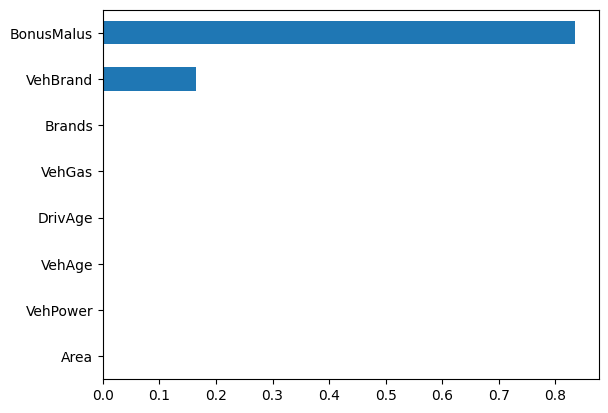

In [234]:
# model 1. Decision Tree
X_train, X_test, y_train, y_test = data_prep (dfx, responses)
dt_base = DecisionTreeRegressor(max_depth = depth, 
                                min_samples_leaf = min_leaves, 
                                min_samples_split = min_split, 
                                random_state = seed)
dt_base.fit(X_train, y_train)
rmse_train, rmse_test, out = model_performance(X_train, X_test, y_train, y_test, dt_base)


Model 2. Random Forrest: here an extra parameter namely the number of estimators is specified. This is the number of bootstrap datasets fed to the decision trees. 

Training RMSE: [1.79302467e+04 3.09065065e-01]
Test RMSE: [4.79764556e+04 3.09407484e-01]


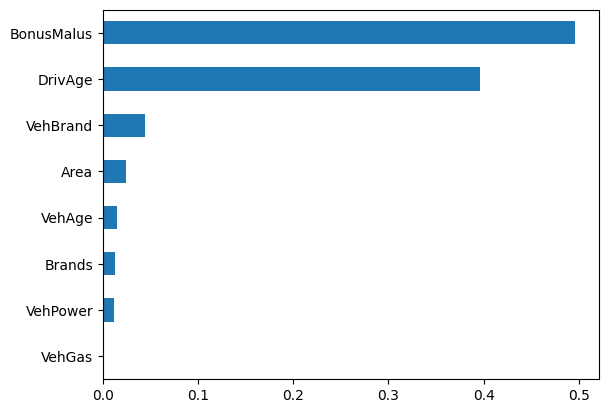

In [235]:
# model 2. Random Forrests
X_train, X_test, y_train, y_test = data_prep (dfx, responses)
rfr = RandomForestRegressor(max_depth = depth, 
                            min_samples_leaf = min_leaves, 
                            min_samples_split = min_split, 
                            random_state = seed, 
                            n_estimators = estimators_num, 
                            n_jobs = -1)
rfr.fit(X_train, np.array(y_train))
rmse_train, rmse_test, out = model_performance(X_train, X_test, y_train, y_test, rfr)

Model 3. Sochastic Gradient Bossting (SGB): this model has three extra parameters. Learning rate, subsample, and max_features. For better generalization the values are set as below. 

Training RMSE: [11912.75561421]
Test RMSE: [49797.36402563]


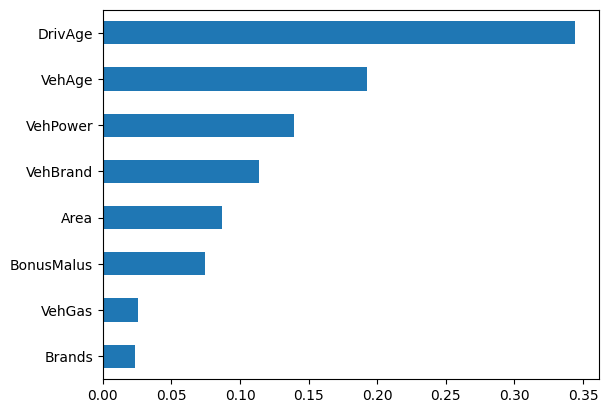

Training RMSE: [0.27778564]
Test RMSE: [0.29779984]


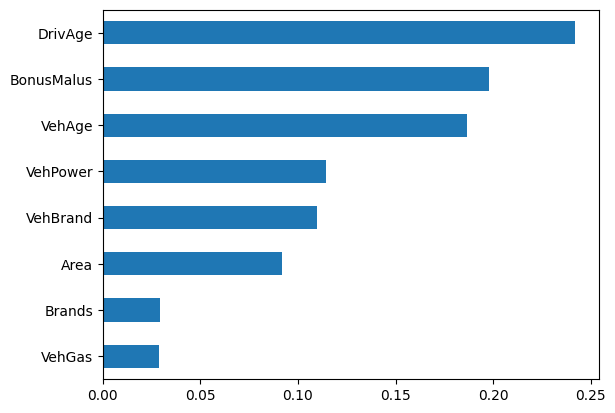

In [236]:
# Model 3. Stochastic Gradient Boosting
X_train, X_test, y_train, y_test = data_prep (dfx, 'ClaimAmount')
SGB_claim = GradientBoostingRegressor(max_depth = depth, 
                                      learning_rate = 0.05, 
                                      n_estimators = estimators_num, 
                                      subsample = 0.2, 
                                      max_features = 0.3, 
                                      random_state = seed)
SGB_claim.fit(X_train, y_train)
rmse_train, rmse_test, out_claim = model_performance(X_train, X_test, y_train, y_test, SGB_claim)
plt.subplots()
X_train, X_test, y_train, y_test = data_prep (dfx, 'Exposure')
SGB_exp = GradientBoostingRegressor(max_depth = depth, 
                                    learning_rate = 0.05, 
                                    n_estimators = estimators_num, 
                                    subsample = 0.2, 
                                    max_features = 0.3, 
                                    random_state = seed)
SGB_exp.fit(X_train, y_train)
rmse_train, rmse_test, out_exp = model_performance(X_train, X_test, y_train, y_test, SGB_exp)

Conclusions
The models perform rather poorly. However, among those which are trained, the decision tree and random forrest has smaller RMSE and hence are better models to predict claim Amount. On the other, SGB does a better job at predicting the exposure with smaller RMSE. We can derive the expect claim amount in a year per policyholder as below

In [237]:
expected_claim = (out_claim/out_exp).mean()
expected_claim

4057.742539346988

To further investiagte the dataset and find a better model one can do the following:

1. Apply hyper parameter tuning
2. Cross-Validation
3. Outlier detection